# Лабораторная работа №5 (Проведение исследований с градиентным бустингом)

## 2. Создание бейзлайна и оценка качества

#### a.	Обучить модели из sklearn (классификации и регрессии градиентным бустингом) для выбранных наборов данных

Нужные библиотеки:

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from scipy.spatial import distance
from collections import Counter

#### Работа с данными

In [3]:
wine_data = pd.read_csv('../data/wine_data.csv')

wine_data["IsGood"] = wine_data["quality"].apply(lambda x: 1 if x >= 7 else 0)

imputer = SimpleImputer(strategy="mean")
wine_data = pd.DataFrame(imputer.fit_transform(wine_data), columns=wine_data.columns)

x_data = wine_data.drop(["quality", "IsGood"], axis=1)

y_class = wine_data["IsGood"]
y_reg = wine_data["quality"]

x_train, x_test, y_train_class, y_test_class = train_test_split(x_data, y_class, test_size=0.2, random_state=42)
x_train, x_test, y_train_reg, y_test_reg = train_test_split(x_data, y_reg, test_size=0.2, random_state=42)


Для упрощения работы создадим универсальные функции:

In [4]:
def test_model_class(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"LogisticRegression:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1-score: {f1_score(y_test, y_pred)}")
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), 
        cmap="Greys", annot=True, fmt="d", 
        xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"]
    )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Confusion matrix")
    plt.show()
    
    return model, y_pred

def test_model_reg(model, X_train,X_test, y_train,  y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"LinearRegression:")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
    print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(y_test, y_pred)}")
    print(f"R-squared (R^2): {r2_score(y_test, y_pred)}")
    
    return model, y_pred

#### Обучение и оценка моделей

LogisticRegression:
Accuracy: 0.871875
F1-score: 0.4810126582278481


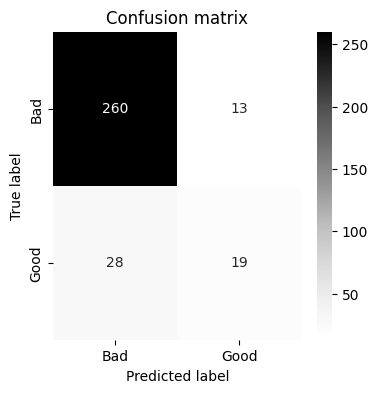

LinearRegression:
Mean Absolute Error (MAE): 0.48459318777850324
Root Mean Squared Error (RMSE): 0.6014890847361276
R-squared (R^2): 0.44638733705813693


In [5]:
_, y_std_pred_class = test_model_class(GradientBoostingClassifier(random_state=42),
    x_train, x_test, y_train_class, y_test_class
)

_, y_std_pred_reg = test_model_reg(GradientBoostingRegressor(random_state=42),
    x_train, x_test, y_train_reg, y_test_reg
)


---
## 3. Улучшение бейзлайна

#### a.	Сформулировать гипотезы (препроцессинг данных, визуализация данных, формирование новых признаков, подбор гиперпараметров на кросс-валидации и т.д.)

Проверим 3 гипотезы для увеличения качества оценки качества вина:

1. Масштабирование признаков
2. Формирование новых признаков
3. Подбор гиперпараметров

#### b.	Проверить гипотезы


##### Масштабируем данные

LogisticRegression:
Accuracy: 0.871875
F1-score: 0.4810126582278481


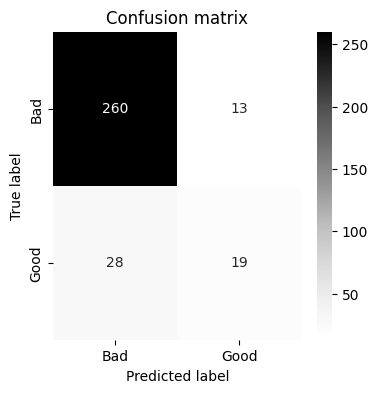

LinearRegression:
Mean Absolute Error (MAE): 0.48459318777850324
Root Mean Squared Error (RMSE): 0.6014890847361276
R-squared (R^2): 0.44638733705813693


In [6]:
scaler_std = StandardScaler()
scaled_x_train = scaler_std.fit_transform(x_train)
scaled_x_test = scaler_std.transform(x_test)

_ = test_model_class(GradientBoostingClassifier(random_state=42),
    scaled_x_train,scaled_x_test,y_train_class,y_test_class
)

_ = test_model_reg(GradientBoostingRegressor(random_state=42),
    scaled_x_train,scaled_x_test,y_train_reg,y_test_reg
)

##### Добавление новых признаков, на основе старых данных

LogisticRegression:
Accuracy: 0.878125
F1-score: 0.5185185185185185


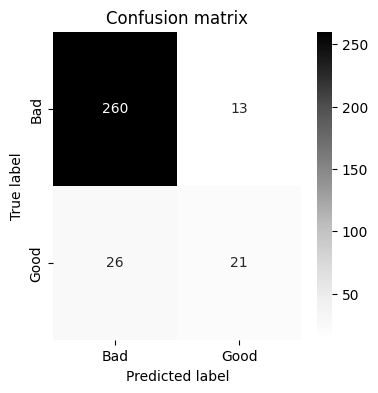

LinearRegression:
Mean Absolute Error (MAE): 0.47649671795878507
Root Mean Squared Error (RMSE): 0.5985393284541906
R-squared (R^2): 0.4518039546745366


In [7]:
x_data_new_features = x_data.copy()

x_data_new_features['bound_so2'] = x_data_new_features['total sulfur dioxide'] - x_data_new_features['free sulfur dioxide']
x_data_new_features['other_acidity'] = x_data_new_features['fixed acidity'] - x_data_new_features['volatile acidity'] - x_data_new_features['citric acid']

_ = test_model_class(GradientBoostingClassifier(random_state=42),
    *train_test_split(x_data_new_features, y_class, test_size=0.2, random_state=42)
)

_ = test_model_reg(GradientBoostingRegressor(random_state=42),
    *train_test_split(x_data_new_features, y_reg, test_size=0.2, random_state=42)
)

##### Подбор гиперпараметров

LogisticRegression:
Accuracy: 0.875
F1-score: 0.5121951219512195


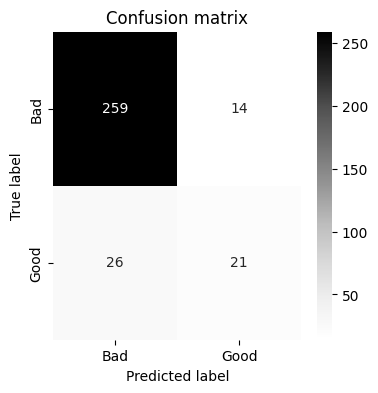

Best parameters: {'learning_rate': 0.1, 'n_estimators': 150}

LinearRegression:
Mean Absolute Error (MAE): 0.4720772312925602
Root Mean Squared Error (RMSE): 0.6004586649460655
R-squared (R^2): 0.44828251631341953
Best parameters: {'learning_rate': 0.1, 'n_estimators': 150}



In [8]:
grid_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100, 150],
}

grid_class = GridSearchCV(GradientBoostingClassifier(random_state=42), grid_params, scoring='accuracy')
grid_class, y_pred_class = test_model_class(grid_class,
    *train_test_split(x_data_new_features, y_class, test_size=0.2, random_state=42)
)
print(f"Best parameters: {grid_class.best_params_}")
print()

grid_reg = GridSearchCV(GradientBoostingRegressor(random_state=42), grid_params, scoring='r2')
grid_reg, y_pred_reg = test_model_reg(grid_reg,
    *train_test_split(x_data_new_features, y_reg, test_size=0.2, random_state=42)
)
print(f"Best parameters: {grid_reg.best_params_}")
print()

#### c-е.	Сформирован улучшенный бейзлайн по результатам проверки гипотез

Обучить модели с улучшенным бейзлайном (для классификации и регрессии) для выбранных наборов данных
Оценить качество моделей с улучшенным бейзлайном (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных

LogisticRegression:
Accuracy: 0.878125
F1-score: 0.5185185185185185


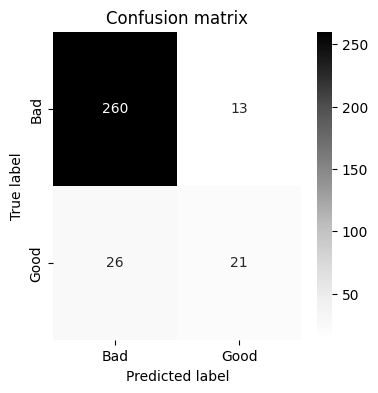

LinearRegression:
Mean Absolute Error (MAE): 0.47649671795878507
Root Mean Squared Error (RMSE): 0.5985393284541906
R-squared (R^2): 0.4518039546745366


In [11]:
wine_data = pd.read_csv('../data/wine_data.csv')
wine_data["IsGood"] = wine_data["quality"].apply(lambda x: 1 if x >= 7 else 0)


imputer = SimpleImputer(strategy="mean")
wine_data = pd.DataFrame(imputer.fit_transform(wine_data), columns=wine_data.columns)

x_data = wine_data.drop(["quality", "IsGood"], axis=1)
x_data_new = x_data.copy()
x_data_new['bound_so2'] = x_data_new['total sulfur dioxide'] - x_data_new['free sulfur dioxide']
x_data_new['other_acidity'] = x_data_new['fixed acidity'] - x_data_new['volatile acidity'] - x_data_new['citric acid']

y_class = wine_data["IsGood"]
y_reg = wine_data["quality"]

x_train, x_test, y_train_class, y_test_class = train_test_split(x_data_new, y_class, test_size=0.2, random_state=42)
x_train, x_test, y_train_reg, y_test_reg = train_test_split(x_data_new, y_reg, test_size=0.2, random_state=42)

_, y_baseline_pred_class = test_model_class(
    GradientBoostingClassifier(random_state=42),
    x_train, x_test, y_train_class, y_test_class
)

_, y_baseline_pred_reg = test_model_reg(
    GradientBoostingRegressor(random_state=42),
    x_train, x_test, y_train_reg, y_test_reg
)

#### f.	Сравнить результаты моделей с улучшенным бейзлайном в сравнении с результатами из пункта 2 

In [12]:
def print_diff(y_test_class, y_pred_class, y_old_pred_class, y_test_reg, y_pred_reg, y_old_pred_reg):
    print(f"Classification:")
    print(f"Increase between old and new predictions classifier:")
    print(f"Accuracy: {accuracy_score(y_test_class, y_pred_class)-accuracy_score(y_test_class, y_old_pred_class)}")
    print(f"F1-score: {f1_score(y_test_class, y_pred_class)-f1_score(y_test_class, y_old_pred_class)}")
    print()
    print(f"Regression:")
    print(f"Increase between old and new predictions regressor:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test_reg, y_pred_reg)-mean_absolute_error(y_test_reg, y_old_pred_reg)}")
    print(f"Root Mean Squared Error (RMSE): {root_mean_squared_error(y_test_reg, y_pred_reg) - root_mean_squared_error(y_test_reg, y_old_pred_reg)}")
    print(f"R-squared: {r2_score(y_test_reg, y_pred_reg)-r2_score(y_test_reg, y_old_pred_reg)}")



print_diff(y_test_class, y_baseline_pred_class, y_std_pred_class, y_test_reg, y_baseline_pred_reg, y_std_pred_reg)

Classification:
Increase between old and new predictions classifier:
Accuracy: 0.006250000000000089
F1-score: 0.03750586029067038

Regression:
Increase between old and new predictions regressor:
Mean Absolute Error: -0.008096469819718177
Root Mean Squared Error (RMSE): -0.002949756281937055
R-squared: 0.005416617616399666


#### g.	Сделать выводы

Сравнение старого и нового бейзлайна реализации классификатора показывает небольшой прирост в качестве модели:

- Accuracy увеличилась на 0.0063, что свидетельствует о незначительном улучшении общей доли правильных предсказаний.
- F1-score вырос на 0.0375, что указывает на более сбалансированную работу модели с точки зрения точности (precision) и полноты (recall).
Эти изменения демонстрируют, что новый бейзлайн классификатора улучшил способность модели справляться с несбалансированными классами и точнее предсказывать метки качества.

Регрессия:
Для регрессии наблюдается небольшое снижение ошибок и улучшение объяснённой дисперсии:

- Mean Absolute Error снизилась на -0.0081, что говорит о незначительном уменьшении среднего отклонения предсказаний от реальных значений.
- Root Mean Squared Error (RMSE) уменьшилась на -0.0029, что указывает на снижение крупных ошибок в предсказаниях.
- R-squared вырос на 0.0054, что свидетельствует об улучшении способности модели объяснять вариативность в данных.
Эти результаты показывают, что новый бейзлайн регрессора более точно отражает связь между физико-химическими параметрами и оценкой качества вина.

---

## 4.	Имплементация алгоритма машинного обучения 

#### a.	Самостоятельно имплементировать алгоритмы машинного обучения (для классификации и регрессии)

Классификация:

In [26]:
from sklearn.tree import DecisionTreeRegressor

class GradientBoostingClassifierCustom:
    def __init__(self, n_estimators=150, max_depth=None, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        self.classes_ = None
        self.learning_rate = learning_rate

    def fit(self, X_train, y_train):
        self.classes_ = np.unique(y_train)
        y_encoded = np.zeros((len(y_train), len(self.classes_)))

        for idx, cls in enumerate(self.classes_):
            y_encoded[:, idx] = (y_train == cls).astype(int)

        self.trees = [[] for _ in range(len(self.classes_))]
        predictions = np.zeros_like(y_encoded, dtype=float)

        for _ in range(self.n_estimators):
            for cls_idx in range(len(self.classes_)):
                residual = y_encoded[:, cls_idx] - predictions[:, cls_idx]
                tree = DecisionTreeRegressor(max_depth=self.max_depth,random_state=42)
                tree.fit(X_train, residual)
                update = self.learning_rate * tree.predict(X_train)

                self.trees[cls_idx].append(tree)
                predictions[:, cls_idx] += update

    def predict(self, X_test):
        predictions = np.zeros((X_test.shape[0], len(self.classes_)))

        for cls_idx in range(len(self.classes_)):
            for tree in self.trees[cls_idx]:
                predictions[:, cls_idx] += self.learning_rate * tree.predict(X_test)

        return self.classes_[np.argmax(predictions, axis=1)]

Регрессия:

In [32]:
class GradientBoostingRegressorCustom:
    def __init__(self, n_estimators=150, max_depth=None, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        self.prediction = 0
        self.learning_rate = learning_rate

    def fit(self, X_train, y_train):
        self.prediction = np.mean(y_train)
        predictions = np.full_like(y_train, self.prediction, dtype=float)

        for _ in range(self.n_estimators):
            residual = y_train - predictions
            tree = DecisionTreeRegressor(max_depth=self.max_depth,random_state=42)
            tree.fit(X_train, residual)
            update = self.learning_rate * tree.predict(X_train)

            self.trees.append(tree)
            predictions += update

    def predict(self, X_test):
        predictions = np.full(X_test.shape[0], self.prediction, dtype=float)

        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X_test)

        return predictions

#### b-с.	Обучить имплементированные модели (для классификации и регрессии) для выбранных наборов данных

Оценить качество имплементированных моделей (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных

Классификация:

LogisticRegression:
Accuracy: 0.896875
F1-score: 0.6292134831460674


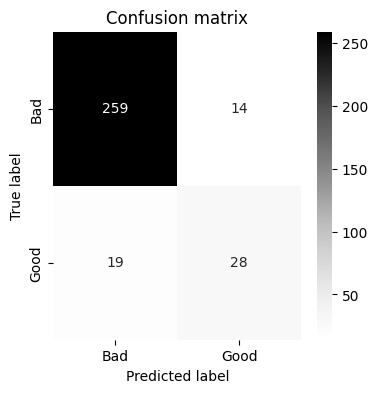

In [30]:
_, y_custom_pred_class = test_model_class(GradientBoostingClassifierCustom(max_depth=10),
    *train_test_split(x_data, y_class, test_size=0.2, random_state=42)
)

Регрессия:

In [37]:
_ , y_custom_pred_reg = test_model_reg(GradientBoostingRegressorCustom(max_depth=5),
    *train_test_split(x_data,y_reg,test_size=0.2,random_state=42)
)

LinearRegression:
Mean Absolute Error (MAE): 0.4429703725155726
Root Mean Squared Error (RMSE): 0.5852119272468275
R-squared (R^2): 0.47594502041729136


#### d.	Сравнить результаты имплементированных моделей в сравнении с результатами из пункта 2 

In [38]:
print_diff(
    y_test_class, y_custom_pred_class,y_std_pred_class,
    y_test_reg,y_custom_pred_reg,y_std_pred_reg
)

Classification:
Increase between old and new predictions classifier:
Accuracy: 0.025000000000000022
F1-score: 0.1482008249182193

Regression:
Increase between old and new predictions regressor:
Mean Absolute Error: -0.04162281526293066
Root Mean Squared Error (RMSE): -0.016277157489300143
R-squared: 0.02955768335915443


#### e.	Сделать выводы

Классификация:

Результаты показывают улучшение качества классификации при использовании кастомной модели:

- Accuracy увеличилась на 0.025, что свидетельствует о небольшой, но заметной точности модели в общем случае.
- F1-score вырос на 0.148, что указывает на значительное улучшение баланса между точностью и полнотой. Это особенно важно для задач с несбалансированными классами, так как модель лучше справляется с классификацией менее представленных категорий.

Регрессия:

Для задачи регрессии также наблюдается улучшения качества:

- Mean Absolute Error (MAE) снизилась на 0.042, что свидетельствует об уменьшении средней абсолютной ошибки.
- Root Mean Squared Error (RMSE) уменьшилась на 0.016, что также указывает на снижение крупного разброса в предсказаниях.
- R-squared улучшился на 0.03, что говорит об увеличении способности модели объяснять вариацию данных.

#### f-h.	Добавить техники из улучшенного бейзлайна (пункт 3с)

Обучить модели (для классификации и регрессии) для выбранных наборов данных

Оценить качество моделей (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных

LogisticRegression:
Accuracy: 0.896875
F1-score: 0.6024096385542169


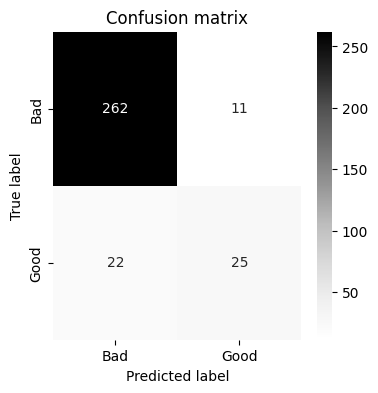

LinearRegression:
Mean Absolute Error (MAE): 0.4550724249770913
Root Mean Squared Error (RMSE): 0.5979493038477638
R-squared (R^2): 0.45288421696176895


In [39]:
wine_data = pd.read_csv('../data/wine_data.csv')
wine_data["IsGood"] = wine_data["quality"].apply(lambda x: 1 if x >= 7 else 0)


imputer = SimpleImputer(strategy="mean")
wine_data = pd.DataFrame(imputer.fit_transform(wine_data), columns=wine_data.columns)

x_data = wine_data.drop(["quality", "IsGood"], axis=1)
x_data_new = x_data.copy()
x_data_new['bound_so2'] = x_data_new['total sulfur dioxide'] - x_data_new['free sulfur dioxide']
x_data_new['other_acidity'] = x_data_new['fixed acidity'] - x_data_new['volatile acidity'] - x_data_new['citric acid']

y_class = wine_data["IsGood"]
y_reg = wine_data["quality"]

x_train, x_test, y_train_class, y_test_class = train_test_split(x_data_new, y_class, test_size=0.2, random_state=42)
x_train, x_test, y_train_reg, y_test_reg = train_test_split(x_data_new, y_reg, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

_, y_custom_baseline_pred_class = test_model_class(
    GradientBoostingClassifierCustom(max_depth=10),
    x_train, x_test, y_train_class, y_test_class
)

_, y_custom_baseline_pred_reg = test_model_reg(
    GradientBoostingRegressorCustom(max_depth=5),
    x_train, x_test, y_train_reg, y_test_reg
)

#### i.	Сравнить результаты моделей в сравнении с результатами из пункта 3

In [40]:
print_diff(
    y_test_class,y_custom_baseline_pred_class,y_baseline_pred_class,
    y_test_reg,y_custom_baseline_pred_reg, y_baseline_pred_reg
)

Classification:
Increase between old and new predictions classifier:
Accuracy: 0.018749999999999933
F1-score: 0.08389112003569843

Regression:
Increase between old and new predictions regressor:
Mean Absolute Error: -0.021424292981693738
Root Mean Squared Error (RMSE): -0.0005900246064267645
R-squared: 0.0010802622872323475


#### j.	Сделать выводы

Классификация:

- Точность (Accuracy) увеличилась на 0.0187 (1.87%), что свидетельствует о повышении общей правильности классификации.
- F1-мера выросла на 0.0839 (8.39%), что особенно важно для задачи с несбалансированными классами, так как это указывает на улучшение как точности, так и полноты классификации.

Регрессия:
- Средняя абсолютная ошибка (MAE) уменьшилась на -0.0214, что указывает на незначительное улучшение в прогнозировании.
- Корень среднеквадратичной ошибки (RMSE) уменьшился на -0.00059, что подтверждает минимальное снижение ошибки.
- R² (коэффициент детерминации) увеличился на 0.0011, что говорит о небольшом, но всё же положительном влиянии новой модели на объяснение дисперсии данных.

В целом, кастомные новые модели демонстрируют улучшения как в задаче классификации, так и в задаче регрессии, что делает их более эффективными и применимыми для решения поставленных задач.